In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir("/content/drive/My Drive")
# !ls


In [2]:
# cd PerformanceDataAnalysis/coding

In [5]:
import re
import os
import pandas as pd

def contrastModel(outputFilePath = 'output/'):
    fileList = os.listdir(outputFilePath)
    fileNumber = len(fileList)
    fileName= []
    for i in range(fileNumber):
        fileName.append(fileList[i].split('.')[0])
        
    # 存储提取的值
    result = []
    for file in fileList:
        filePath = os.path.join(outputFilePath, file)
        with open(filePath, 'r', encoding='utf-8') as f:
            content = f.read()
            field_lengths_matches = re.findall(r"Field lengths: \{([^}]+)\}", content)
            key_score_dict_matches = re.findall(r"KeyScore Dict: \{([^}]+)\}", content)
            result.append([field_lengths_matches, key_score_dict_matches])


    keyNameList = []
    tempResult = result[0][0]
    tempNameSingle = [item.strip() for sublist in [item.split(',') for item in tempResult] for item in sublist]
    for i in range(len(tempNameSingle)):
        keyNameList.append(tempNameSingle[i].split(':')[0])

  
    # columnName的值由keyNameList[i] + '_Number' 和 keyNameList[i] + '_Score'组成
    indexName = []
    for i in range(len(keyNameList)):
        indexName.append(keyNameList[i] + '_Number')
        indexName.append(keyNameList[i] + '_Score')


    valueList = []
    for i in range(len(result)):
        tempList = []
        for j in range(len(result[i][0])):
            number_match = re.findall(r": \d+", result[i][0][j])
            score_match = re.findall(r": \d+", result[i][1][j])
            numberList = []
            scoreList = []
            for k in range(len(number_match)):
                numberList.append(int(number_match[k].split(': ')[1]))
                scoreList.append(int(score_match[k].split(': ')[1]))
            for number in range(len(numberList)):
                tempList.append(numberList[number])
                tempList.append(scoreList[number])
        valueList.append(tempList)


    df = pd.DataFrame(columns=fileName, index=indexName)
    for i in range(len(fileName)):
        df.loc[:,fileName[i]] = valueList[i]
    
    return df


df = contrastModel()
df.head(len(df))

,residual_01,residual_02,residual_03,residual_04,residual_05,residual_06,residual_07
'#wzry_training_time'_Number,1833,1837,1846,1831,1837,1837,1830
'#wzry_training_time'_Score,1444,1454,1454,1423,1469,1465,1443
'#ping_avg'_Number,1840,1840,1840,1840,1840,1840,1840
'#ping_avg'_Score,5,3,5,0,1,0,0
'#speccpu2017_intspeed'_Number,1383,1337,1348,1376,1349,1330,1357
'#speccpu2017_intspeed'_Score,514,900,981,1004,256,262,980
'#speccpu2017_fprate'_Number,1178,1208,1210,1210,1235,1248,1263
'#speccpu2017_fprate'_Score,889,880,1001,947,943,922,973
'#speccpu2017_intrate'_Number,1178,1193,1181,1152,1155,1161,1119
'#speccpu2017_intrate'_Score,937,853,930,937,844,946,806


# 残差模块

In [ ]:
import json
import re
import heapq
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


class MyDataset(Dataset):
    def __init__(self, input, output):
        self.input = input
        self.output = output
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input[idx], dtype=torch.float32)  
        y = torch.tensor(self.output[idx], dtype=torch.float32)  
        return x, y



class ResidualBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        self.bn1 = nn.BatchNorm1d(output_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(output_size, output_size)
        self.bn2 = nn.BatchNorm1d(output_size)

    def forward(self, x):
        identity = x
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x += identity  # 残差连接
        x = F.relu(x)
        return x


class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()

        self.residual_block1 = ResidualBlock(256, 256)
        self.residual_block2 = ResidualBlock(256, 256)
        self.residual_block3 = ResidualBlock(256, 256)

        self.fc2 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(0.5)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.residual_block3(x)

        x = self.fc2(x)
        return x


def getKeyNum(df):
    # 提取 results 列中带有 "#" 号的字段
    pattern = r'#\w+'  
    results = df['results'].str.cat(sep=' ')  # 将所有 results 列的数据合并为一个字符串
    hashtags = set(re.findall(pattern, results))  # 使用正则表达式提取带 "#" 号的字段，并去重

    # 统计每个带 "#" 号的字段在整个文件中出现的次数
    hashtags_dict = {}
    for hashtag in hashtags:
        count = results.count(hashtag)
        hashtags_dict[hashtag] = count
    return hashtags_dict


def getTop10Key(hashtags_dict):
    # 获取字典中数量前十的字段
    top_n = 10  # 自定义获取前几个字段
    top_n_fields = heapq.nlargest(top_n, hashtags_dict, key=hashtags_dict.get)
    
    print("数量前十的字段：")
    for field in top_n_fields:
        print("字段名: {:<30s} 出现次数: {:d}".format(field, hashtags_dict[field]))


def get_input_output_Speed_Multi(Tdf, fields, keys_to_extract):
    # 选择需要提取的字段
    df = Tdf.copy()
    
    # 对dimension列进行预处理
    df['dimension'] = df['dimension'].apply(lambda x: json.loads(x))
    
    for key in keys_to_extract:
        df[key] = df['dimension'].apply(lambda x: 'None' if x.get(key) in [None, ''] else x.get(key))

    # 对cvm_cpu进行数值化处理
    df['cvm_cpu'] = df['cvm_cpu'].apply(pd.to_numeric, errors='coerce').fillna(-1)
    # 对cvm_memory进行数值化处理，通过正则表达式提取出数字
    df['cvm_memory'] = df['cvm_memory'].apply(lambda x: re.findall(r'\d+', x)[0] if re.findall(r'\d+', x) else '').apply(pd.to_numeric, errors='coerce').fillna(-1)

    # 筛选出符合要求的行
    df_filtered = df[df['results'].apply(lambda x: any(field in x for field in fields))]  # 检查任一字段是否出现在 results 中

    # 从results中提取出field对应的值
    df_output = pd.DataFrame(df_filtered['results'].apply(lambda x: json.loads(x)).tolist(), index=df_filtered.index)
    df_output = df_output[fields]  # 提取多个字段的值
    df_output = df_output.fillna(0)  # 将缺失值填充为 0

    # 将input和output分别转成dataframe
    df_input = df_filtered[keys_to_extract + ['results_key']]
    df_output = pd.DataFrame(df_output)

    # 将input和output合并成一个dataframe
    df_result = df_input.join(df_output)
    df_result = df_result.reset_index(drop=True)

    return df_result


def replace_zero_with_stat(df_result, fields, stat='None'):
    if stat == 'mean':
        stat_values = df_result[fields].mean()
        stat_values = stat_values.apply(lambda x: round(x, 6))
        df_result[fields] = df_result[fields].replace(0, stat_values)
        return df_result
    elif stat == 'median':
        stat_values = df_result[fields].median()
        stat_values = stat_values.apply(lambda x: round(x, 6))
        df_result[fields] = df_result[fields].replace(0, stat_values)
        return df_result
    else:
        return df_result
    

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(dataloader)


def modify_values(df, your_keys, your_operators, values):
    for key, operator, value in zip(your_keys, your_operators, values):
        df[key] = df[key].apply(lambda x: eval(f'x {operator} {value}'))
    return df


def parse_string(input_string):
    yourKey = []
    yourOperator = []
    value = []
    expressions = input_string.split(',')

    for expression in expressions:
        expression = expression.strip()
        # 使用正则表达式匹配键、操作符和值
        matches = re.findall(r'(#\w+)\s*([*/])\s*(\d+)', expression)
        for match in matches:
            yourKey.append(match[0])
            yourOperator.append(match[1])
            value.append(float(match[2]))

    return yourKey, yourOperator, value




FilePath='data/processed_files/super_pi.csv'                                            # 换数据集请修改此处

FileData=pd.read_csv(FilePath)
keyNumDict=getKeyNum(FileData)
getTop10Key(keyNumDict)
your_fields = list(keyNumDict.keys())
your_fields = your_fields[:10]


# your_fields = ['#stream_triad', '#stream_copy']     # 手动挑选字段请修改此处

valid_fields = [field for field in your_fields if field in keyNumDict]
invalid_fields = set(your_fields) - set(valid_fields)
if invalid_fields:
    print("Fields {} not in dictionary, have been removed".format(invalid_fields))
your_fields = valid_fields


keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'cvm_cpu_type', 'cvm_version','cvm_gpu_type','host_cpu_type','host_memory_type','tool_version','component_version','host_manufacturer_name','host_type']
# keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'cvm_cpu_type', 'cvm_version']
df_result = get_input_output_Speed_Multi(FileData, your_fields, keys_to_extract)

df_result = replace_zero_with_stat(df_result, your_fields)


# input_string = '#super_pi_user_time* 100, #super_pi_sys_time /1000, #super_pi_real_time/1000'
# yourKey, yourOperator, value = parse_string(input_string)
# df_result = modify_values(df_result, yourKey, yourOperator, value)


tempKey = keys_to_extract.copy()
tempKey.append('results_key')
print(keys_to_extract)
print(tempKey)

inPutDF = df_result[tempKey]
outPutDF = df_result[your_fields]

print(inPutDF.shape)
print(outPutDF.shape)

inPutDF.loc[:, 'cvm_cpu'] = pd.to_numeric(inPutDF['cvm_cpu'])
inPutDF.loc[:, 'cvm_memory'] = pd.to_numeric(inPutDF['cvm_memory'])
one_hot_df = pd.get_dummies(inPutDF, columns=tempKey[2:]).loc[:, :]
X = one_hot_df.values
y = outPutDF.values
print(X.shape)
print(y.shape)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

input_size = X.shape[1]
output_size = y.shape[1]
print('input_size: ', input_size)
print('output_size: ', output_size)


model = MyModel(input_size, output_size).to(device)
dataset = MyDataset(X, y)


train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 早停
num_epochs = 100 
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 100
early_stop_counter = 0

# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) scheduler.step()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10) scheduler.step(val_loss) 若使用请添加到val_losses.append(val_loss)下一行
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)


for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    val_loss = evaluate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break


# 将train_loss和val_loss保存到loss.txt
with open('loss.txt', 'w') as f:
    for i in range(len(train_losses)):
        f.write(str(train_losses[i]) + ' ' + str(val_losses[i]) + '\n')



test_loss = evaluate(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")


torch.save(model.state_dict(), 'model.pth')


model = MyModel(input_size, output_size).to(device)
model.load_state_dict(torch.load('model.pth'))


model.eval()
predictions = []
targets = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions.extend(outputs.tolist())
        targets.extend(labels.tolist())


df_predictions = pd.DataFrame({'Prediction': predictions, 'Target': targets})

for field in your_fields:
    target_field = field + '_Target'
    prediction_field = field + '_Prediction'
    index = your_fields.index(field)

    df_predictions[target_field] = df_predictions['Target'].apply(lambda x: round(x[index], 6))
    df_predictions[prediction_field] = df_predictions['Prediction'].apply(lambda x: round(x[index], 6))

df_predictions.drop(['Prediction', 'Target'], axis=1, inplace=True)
df_test = df_predictions.copy()


for field in your_fields:
    df_test[field + '_absScore'] = (1-(abs(df_test[field + '_Target'] - df_test[field + '_Prediction']) / df_test[field + '_Target']))*100



field_lengths = {field: len(df_test[df_test[field + '_Target'] != 0]) for field in your_fields}
print("Field lengths:", field_lengths)

KeyScoreDict = {field: len(df_test[(df_test[field + '_absScore'] >= 90) & (df_test[field + '_absScore'] <= 100)]) for field in your_fields}
print("KeyScore Dict:", KeyScoreDict)

# 全连接模块

In [ ]:
import json
import re
import heapq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def getKeyNum(df):
    # 提取 results 列中带有 "#" 号的字段
    pattern = r'#\w+'  
    results = df['results'].str.cat(sep=' ')  # 将所有 results 列的数据合并为一个字符串
    hashtags = set(re.findall(pattern, results))  # 使用正则表达式提取带 "#" 号的字段，并去重

    # 统计每个带 "#" 号的字段在整个文件中出现的次数
    hashtags_dict = {}
    for hashtag in hashtags:
        count = results.count(hashtag)
        hashtags_dict[hashtag] = count
    return hashtags_dict


def showKeyNum(hashtags_dict):
    # 将字典按值从大到小排序
    hashtags_dict_sorted = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)

    # 提取排序后的键和值
    hashtags_sorted = [item[0] for item in hashtags_dict_sorted]
    counts_sorted = [item[1] for item in hashtags_dict_sorted]

    # 绘制柱状图
    plt.figure(figsize=(30, 10))  
    plt.bar(hashtags_sorted, counts_sorted)
    # 在柱状图上添加数值标签
    for a, b in zip(hashtags_sorted, counts_sorted):
        plt.text(a, b+0.05, '%.0f' % b, ha='center', va='bottom', fontsize=11)
    plt.xticks(rotation=90)  
    plt.xlabel('Hashtags')  
    plt.ylabel('Counts')  
    plt.title('Hashtags Counts')  
    plt.show()


def getTop10Key(hashtags_dict):
    # 获取字典中数量前十的字段
    top_n = 10  # 自定义获取前几个字段
    top_n_fields = heapq.nlargest(top_n, hashtags_dict, key=hashtags_dict.get)
    
    print("数量前十的字段：")
    for field in top_n_fields:
        print("字段名: {:<30s} 出现次数: {:d}".format(field, hashtags_dict[field]))


def get_input_output_Speed_Multi(Tdf, fields, keys_to_extract):
    # 选择需要提取的字段
    df = Tdf.copy()
    
    # 对dimension列进行预处理
    df['dimension'] = df['dimension'].apply(lambda x: json.loads(x))
    
    for key in keys_to_extract:
        df[key] = df['dimension'].apply(lambda x: 'None' if x.get(key) in [None, ''] else x.get(key))

    # 对cvm_cpu进行数值化处理
    df['cvm_cpu'] = df['cvm_cpu'].apply(pd.to_numeric, errors='coerce').fillna(-1)
    # 对cvm_memory进行数值化处理，通过正则表达式提取出数字
    df['cvm_memory'] = df['cvm_memory'].apply(lambda x: re.findall(r'\d+', x)[0] if re.findall(r'\d+', x) else '').apply(pd.to_numeric, errors='coerce').fillna(-1)

    # 筛选出符合要求的行
    df_filtered = df[df['results'].apply(lambda x: any(field in x for field in fields))]  # 检查任一字段是否出现在 results 中

    # 从results中提取出field对应的值
    df_output = pd.DataFrame(df_filtered['results'].apply(lambda x: json.loads(x)).tolist(), index=df_filtered.index)
    df_output = df_output[fields]  # 提取多个字段的值
    df_output = df_output.fillna(0)  # 将缺失值填充为 0

    # 将input和output分别转成dataframe
    df_input = df_filtered[keys_to_extract + ['results_key']]
    df_output = pd.DataFrame(df_output)

    # 将input和output合并成一个dataframe
    df_result = df_input.join(df_output)
    df_result = df_result.reset_index(drop=True)

    return df_result


def replace_zero_with_stat(df_result, fields, stat='None'):
    if stat == 'mean':
        stat_values = df_result[fields].mean()
        stat_values = stat_values.apply(lambda x: round(x, 6))
        df_result[fields] = df_result[fields].replace(0, stat_values)
        return df_result
    elif stat == 'median':
        stat_values = df_result[fields].median()
        stat_values = stat_values.apply(lambda x: round(x, 6))
        df_result[fields] = df_result[fields].replace(0, stat_values)
        return df_result
    else:
        return df_result
    



import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


class MyDataset(Dataset):
    def __init__(self, input, output):
        self.input = input
        self.output = output
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input[idx], dtype=torch.float32)  
        y = torch.tensor(self.output[idx], dtype=torch.float32)  
        return x, y


class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        
        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.relu5 = nn.ReLU()
        
        self.fc6 = nn.Linear(64, 16)
        self.bn6 = nn.BatchNorm1d(16)
        self.relu6 = nn.ReLU()
        
        self.fc7 = nn.Linear(16, output_size)
        self.dropout = nn.Dropout(0.5)
        
        # 初始化权重
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc5.weight)
        nn.init.xavier_uniform_(self.fc6.weight)
        nn.init.xavier_uniform_(self.fc7.weight)
        
    def forward(self, x):
        def apply_layers(x, fc, bn, relu):
            x = fc(x)
            x = bn(x)
            x = relu(x)
            x = self.dropout(x)
            return x
        x = apply_layers(x, self.fc1, self.bn1, self.relu1)
        x = apply_layers(x, self.fc2, self.bn2, self.relu2)
        x = apply_layers(x, self.fc3, self.bn3, self.relu3)
        x = apply_layers(x, self.fc4, self.bn4, self.relu4)
        x = apply_layers(x, self.fc5, self.bn5, self.relu5)
        x = apply_layers(x, self.fc6, self.bn6, self.relu6)
        x = self.fc7(x)
        return x


def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(dataloader)


def modify_values(df, your_keys, your_operators, values):
    for key, operator, value in zip(your_keys, your_operators, values):
        df[key] = df[key].apply(lambda x: eval(f'x {operator} {value}'))
    return df


def parse_string(input_string):
    yourKey = []
    yourOperator = []
    value = []
    expressions = input_string.split(',')

    for expression in expressions:
        expression = expression.strip()
        # 使用正则表达式匹配键、操作符和值
        matches = re.findall(r'(#\w+)\s*([*/])\s*(\d+)', expression)
        for match in matches:
            yourKey.append(match[0])
            yourOperator.append(match[1])
            value.append(float(match[2]))

    return yourKey, yourOperator, value

In [ ]:
FilePath='data/processed_files/stream.csv'                                            # 换数据集请修改此处

FileData=pd.read_csv(FilePath)
keyNumDict=getKeyNum(FileData)
getTop10Key(keyNumDict)
your_fields = list(keyNumDict.keys())

数量前十的字段：
字段名: #stream_copy                   出现次数: 94146
字段名: #stream_triad                  出现次数: 94146
字段名: #stream_scale                  出现次数: 8369
字段名: #stream_add                    出现次数: 8369
字段名: #stream_ht2_triad              出现次数: 6038
字段名: #stream_ht2_copy               出现次数: 6038
字段名: #stream_ht1_triad              出现次数: 6038
字段名: #stream_ht1_copy               出现次数: 6038
字段名: #hrtimer_min                   出现次数: 748
字段名: #hrtimer_avg                   出现次数: 748


In [ ]:
your_fields = ['#stream_triad', '#stream_copy']     # 手动挑选字段请修改此处

valid_fields = [field for field in your_fields if field in keyNumDict]
invalid_fields = set(your_fields) - set(valid_fields)
if invalid_fields:
    print("Fields {} not in dictionary, have been removed".format(invalid_fields))
your_fields = valid_fields

keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'cvm_cpu_type', 'cvm_version','cvm_gpu_type','host_cpu_type','host_memory_type','tool_version','component_version','host_manufacturer_name','host_type']
df_result = get_input_output_Speed_Multi(FileData, your_fields, keys_to_extract)

df_result = replace_zero_with_stat(df_result, your_fields)


# input_string = '#super_pi_user_time* 100, #super_pi_sys_time /1000, #super_pi_real_time/1000'
# yourKey, yourOperator, value = parse_string(input_string)
# df_result = modify_values(df_result, yourKey, yourOperator, value)

tempKey = keys_to_extract.copy()
tempKey.append('results_key')
print(keys_to_extract)
print(tempKey)

inPutDF = df_result[tempKey]
outPutDF = df_result[your_fields]

print(inPutDF.shape)
print(outPutDF.shape)

inPutDF.loc[:, 'cvm_cpu'] = pd.to_numeric(inPutDF['cvm_cpu'])
inPutDF.loc[:, 'cvm_memory'] = pd.to_numeric(inPutDF['cvm_memory'])
one_hot_df = pd.get_dummies(inPutDF, columns=tempKey[2:]).loc[:, :]
X = one_hot_df.values
y = outPutDF.values
print(X.shape)
print(y.shape)

device:  cuda:0
input_size:  903
output_size:  2
Epoch 1/10
Train Loss: 3215202193.8551 | Val Loss: 3165803279.3484
Epoch 2/10
Train Loss: 3204172618.6667 | Val Loss: 3157086420.8507
Epoch 3/10
Train Loss: 3182661897.1014 | Val Loss: 3127669510.3710
Epoch 4/10
Train Loss: 3155199785.4493 | Val Loss: 3114803071.4208
Epoch 5/10
Train Loss: 3123322370.5507 | Val Loss: 3073247044.6335
Epoch 6/10
Train Loss: 3085179608.8116 | Val Loss: 3011734926.4796
Epoch 7/10
Train Loss: 3041007988.8116 | Val Loss: 2989736151.1674
Epoch 8/10
Train Loss: 2995523415.8841 | Val Loss: 2944045897.5566
Epoch 9/10
Train Loss: 2945011666.2609 | Val Loss: 2945847071.2760
Epoch 10/10
Train Loss: 2885557491.9420 | Val Loss: 2848250259.6923


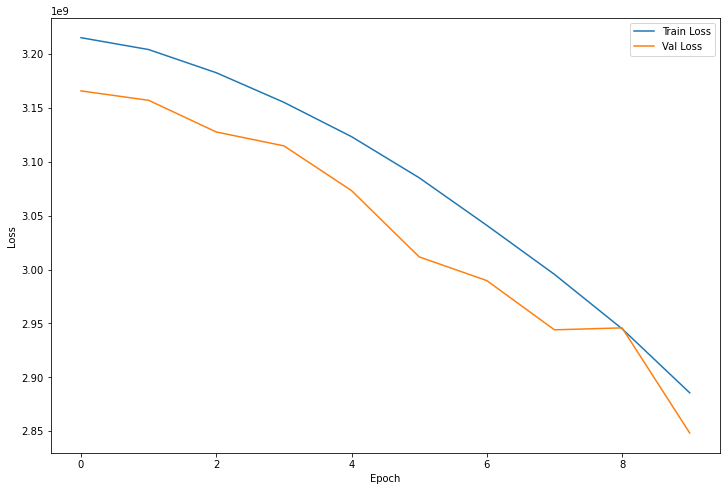

Test Loss: 2714359602.8108


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

input_size = X.shape[1]
output_size = y.shape[1]
print('input_size: ', input_size)
print('output_size: ', output_size)


model = MyModel(input_size, output_size).to(device)
dataset = MyDataset(X, y)


train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 早停
num_epochs = 10 
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 100
early_stop_counter = 0

# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) scheduler.step()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10) scheduler.step(val_loss) 若使用请添加到val_losses.append(val_loss)下一行
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)


for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    val_loss = evaluate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break


plt.figure(figsize=(12, 8))
epochs = len(train_losses)  
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


test_loss = evaluate(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")


torch.save(model.state_dict(), 'model.pth')

In [ ]:
model = MyModel(input_size, output_size).to(device)
model.load_state_dict(torch.load('model.pth'))


model.eval()
predictions = []
targets = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions.extend(outputs.tolist())
        targets.extend(labels.tolist())


df_predictions = pd.DataFrame({'Prediction': predictions, 'Target': targets})

for field in your_fields:
    target_field = field + '_Target'
    prediction_field = field + '_Prediction'
    index = your_fields.index(field)

    df_predictions[target_field] = df_predictions['Target'].apply(lambda x: round(x[index], 6))
    df_predictions[prediction_field] = df_predictions['Prediction'].apply(lambda x: round(x[index], 6))

df_predictions.drop(['Prediction', 'Target'], axis=1, inplace=True)
df_test = df_predictions.copy()


for field in your_fields:
    df_test[field + '_absScore'] = (1-(abs(df_test[field + '_Target'] - df_test[field + '_Prediction']) / df_test[field + '_Target']))*100


df_test.to_csv('test_result.csv', index=False)


field_lengths = {field: len(df_test[df_test[field + '_Target'] != 0]) for field in your_fields}
print("Field lengths:", field_lengths)

KeyScoreDict = {field: len(df_test[(df_test[field + '_absScore'] >= 90) & (df_test[field + '_absScore'] <= 100)]) for field in your_fields}
print("KeyScore Dict:", KeyScoreDict)